  Activating project at `~/LCP/fish-track/HMC`


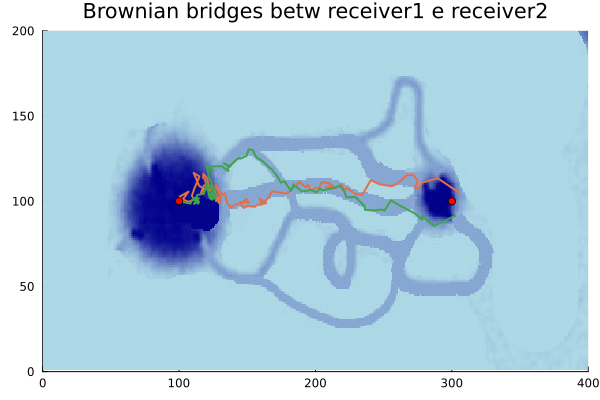

[ Info: Optimizing posterior for a MAP starting point…


No Matches in `~/LCP/fish-track/HMC/Project.toml`


[ Info: Running Pigeons parallel tempering…
┌ Warning: It looks like sample_iid!() is not implemented for a 
│ reference_log_potential of type FishPriorPotential{TransformVariables.ArrayTransformation{TransformVariables.TransformTuple{@NamedTuple{x::TransformVariables.Identity, y::TransformVariables.Identity}}, 1}, Vector{Float64}}. 
│ Instead, using step!(). 
└ @ Pigeons ~/.julia/packages/Pigeons/AU55F/src/targets/target.jl:51


──────────────────────────────────────────────────────────────────────────────────────────────────
  scans        Λ        time(s)    allc(B)  log(Z₁/Z₀)   min(α)     mean(α)    min(αₑ)   mean(αₑ) 
────────── ────────── ────────── ────────── ────────── ────────── ────────── ────────── ──────────
        2          0       4.87   5.66e+09       -345          1          1      0.997          1 
        4          0       9.07   1.13e+10       -573          1          1      0.997          1 
        8          0       16.8   2.25e+10       -363          1          1      0.998          1 
──────────────────────────────────────────────────────────────────────────────────────────────────


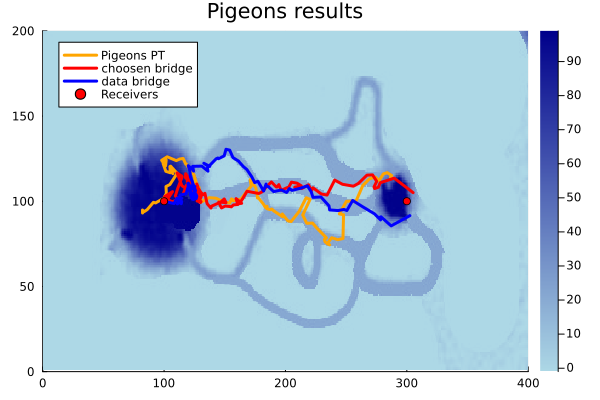

In [1]:
## -------------------------------------------------------
##
## Find a fish with HMC
##
## February 15, 2024 -- Andreas Scheidegger
## andreas.scheidegger@eawag.ch
## -------------------------------------------------------

import Pkg

# prior for sigma  -> reference
# explorers
# way to parallelize

Pkg.activate(".")
Pkg.instantiate()

using Images: load, Gray, channelview
using Plots

include("find_PT3.jl")


# -----------
# Notes
#
# - N.B., this is prototype and is not working properly!!!
# - Meaning, even with simple simulated data it does not converge.
#
# Potential issues / todos:
#
# - land/no land results currently in a discontinuity in `log_prob_signal`, something HMC
#   does not like at all. We should smooth this somehow.
#   A simple unbounded likelihood (e.g. normal), however results in trajectories that are
#   often on land, or are even leaving the bounding box. Hence, we need a smarter formulation for that.
#
# - Use better initial values, i.e. optimize the posterior first. This alone may already
#   be a challenging.
#
# - Try Enzyme.jl or Mooncake.jl for faster Automatic differentiation
#
# - Test HMC with tempering:
#   - Pigeons.jl
#   - MCMCTempering.jl ?
#
# - Test Repelling-Attracting HMC?  https://github.com/sidv23/ra-hmc


#--------- basics
# Load bathymetry, negative values are treated as land:
bathymetry_map = channelview(Gray.(load("bathymetry_maps/map_channel_maze3.jpeg"))) * 100 .- 1;
bathymetry_int = extrapolate(interpolate(bathymetry_map, BSpline(Linear())),-1.0);

receiver1 = Receiver((x=100, y=100), k=50.0, dist=30.0)
receiver2 = Receiver((x=300, y=100), dist=50.0)

#--------- bridges
#Building bridges from receiver1 to receiver 2, which is a way to get all (if n_bridges, tmax and sigma are big enough to explore all the channels) the plausible 
#paths that the fish may have followed:
tmax = 100                            
n_bridges = 100
bridges = []
for _ in 1:n_bridges
    bridge = simulate_bridge(tmax; A=receiver1, B=receiver2, σ=3.0, α=0.7, bathymetry_int=bathymetry_int)
    if bridge !== nothing
        push!(bridges, bridge)
    end
end
bridges = filter(!isnothing, bridges)  # keep just the valid trajectories
bridges_x = [[p.x for p in bridge] for bridge in bridges]
bridges_y = [[p.y for p in bridge] for bridge in bridges]
plt = heatmap(bathymetry_map[end:-1:1,:],
              xlim=(0, 400), ylim=(0, 200),
              color=:blues,
              legend=false,
              title="Brownian bridges betw receiver1 e receiver2")
for i in 1:length(bridges)
    plot!(plt, bridges_x[i], bridges_y[i], lw=2)
end

s_init = bridges[1] #The trajectory that we try to optimize via PT
s_depth = bridges[2] #The trajectory from which we extract the depth data


#Plotting the accepted bridges:
xs_d = [p.x for p in s_depth]
ys_d = [p.y for p in s_depth]

xs = [p.x for p in s_init]
ys = [p.y for p in s_init]

scatter!(plt, [receiver1.x, receiver2.x], [receiver1.y, receiver2.y], color=:red, label="Receivers")
display(plt)
plt = heatmap(bathymetry_map[end:-1:1,:],
              xlim=(0, 400), ylim=(0, 200),
              color=:blues,
              legend=false,
              title="Brownian bridges betw receiver1 e receiver2")
plot!(plt, xs, ys, lw=3, color=:red, label="bridge")


#--------- data
# Accustic signals:
receivers = [receiver1, receiver2]
Yaccustic = build_Yaccustic_from_trajectory(s_init, receivers)

#Depth signal:
Ydepth = Tuple{Int, Float64, DepthGauge}[] 
depthgauge = DepthGauge()
sigma_noise=0.5
for (t, point) in enumerate(bridges[1])
    # Get the depth from the bathymetry
    d = get_depth((x=point.x, y=point.y), bathymetry_int)
    
    # Add normal noise with standard deviation sigma_noise
    noisy_d = d + randn() * sigma_noise

    push!(Ydepth, (t+1, noisy_d, depthgauge))
end


#--------- PT 
@info "Optimizing posterior for a MAP starting point…"              

#Setting the problem characteristics:
mapping = TransformVariables.as(Array, 
                                TransformVariables.as((x = TransformVariables.asℝ, y = TransformVariables.asℝ)),
                                tmax)
v_init = TransformVariables.inverse(mapping, s_init)


dimension(lp::FishLogPotential) = length(lp.v_init)
logdensity(lp::FishLogPotential, v::AbstractVector) = lp(v)
capabilities(::FishLogPotential) = LogDensityProblems.LogDensityOrder{0}()

dimension(lp::FishPriorPotential) = length(lp.v_init)
logdensity(lp::FishPriorPotential, v::AbstractVector) = lp(v)
capabilities(::FishPriorPotential) = LogDensityProblems.LogDensityOrder{0}()

LogDensityProblems.dimension(lp::FishLogPotential) = length(lp.v_init)

Pigeons.initialization(lp::FishLogPotential, rng::AbstractRNG, ::Int) = lp.v_init


#Actually running pigeons:
import Pkg
Pkg.status("PigeonsMCMCChainsExt")

@info "Running Pigeons parallel tempering…"

fish_prior_lp = FishPriorPotential(mapping, v_init)
fish_lp = FishLogPotential(Ydepth, Yaccustic, bathymetry_int, mapping, v_init)
pt = pigeons(
    target            = fish_lp,               # log posterior to smaple from
    reference         = fish_prior_lp,         # reference distribution (that coincides with the distribution at beta=0)
    seed              = 1234,                  
    n_rounds          = 3,                     # up to 2^nround–1 scans
    n_chains          = 100,                    
    checkpoint        = false,                
    multithreaded     = true,                  
    #=explorer          = AutoMALA(
                           step_size            = 6.0,           # passo iniziale MALA
                           base_n_refresh       = 13,     #13        # passi base per esplorazione
                           exponent_n_refresh   = 0.5,           # scala con √dim
                           default_autodiff_backend = :ForwardDiff    # backend autodiff
                       ),=#
    record            = [traces; record_default()]  # registra traiettorie + diagnostica
)
pt_samples  = Chains(pt)         
#my_plot = StatsPlots.plot(pt_samples)
#StatsPlots.savefig(my_plot, "julia_posterior_densities_and_traces.svg");

cold_last_v = pt_samples.value[end, 1: 2*tmax] |> vec
cold_last_S = TransformVariables.transform(mapping, cold_last_v)

#Some plotting:
xs_pigeons = [p.x for p in cold_last_S] #extracting trajectories
ys_pigeons = [p.y for p in cold_last_S]

plt = heatmap(bathymetry_map[end:-1:1, :],
              xlim=(0, 400), ylim=(0, 200),
              color=:blues,
              title="Pigeons results")
plot!(plt, xs_pigeons, ys_pigeons, lw=3, color=:orange, label="Pigeons PT")
plot!(plt, xs, ys, lw=3, color=:red, label="choosen bridge")
plot!(plt, xs_d, ys_d, lw=3, color=:blue, label="data bridge")
scatter!(plt, [receiver1.x, receiver2.x], [receiver1.y, receiver2.y], color=:red, label="Receivers")
display(plt)


# TO CHECK THE USEFULNESS OF THE FOLLOWING PLOT

#=logposteriors = [logdensity(fish_lp, pt_samples.value[i, 1:2*tmax]) for i in 1:size(pt_samples.value, 1)]
plot(logposteriors, xlabel="iteration", ylabel="Log-posterior", title="log-posterior evolution")


# Supponiamo che ogni sample sia un vettore di lunghezza 200 (100 punti x,y)
n_points = tmax
n_samples = size(pt_samples.value, 1)

# Estrai solo la catena fredda (di solito la prima o l'ultima, verifica con la doc di Pigeons)
# Qui assumiamo che la catena fredda sia la prima
for i in 1:n_samples
    v = pt_samples.value[i, 1:2*n_points]
    S = TransformVariables.transform(mapping, v)
    xs = [p.x for p in S]
    ys = [p.y for p in S]
    plot!(xs, ys, alpha=0.2, color=:orange, label=false)
end

# Plotta la batimetria sotto
heatmap!(bathymetry_map[end:-1:1, :], xlim=(0, 400), ylim=(0, 200), color=:blues, alpha=0.3, legend=false)=#
